In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import datetime

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    
load_dotenv()

True

In [6]:
# load datasets
from training.utils import date_range, preprocess_c

df_train = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2019, 11, 1), 
        datetime.date(2020, 2, 1),
        datetime.timedelta(days=1),
    )
])
df_val = pd.concat([
    pd.read_csv(f'../datasets/d{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        datetime.date(2020, 2, 1), 
        datetime.date(2020, 2, 15),
        datetime.timedelta(days=1),
    )
])

X1_train, X2_train, y_train = preprocess_c(df_train)
X1_val, X2_val, y_val = preprocess_c(df_val)

X1_train.shape, X2_train.shape, y_train.shape, X1_val.shape, X2_val.shape, y_val.shape

((1598125, 1, 4),
 (1598125, 30, 4),
 (1598125, 4),
 (263845, 1, 4),
 (263845, 30, 4),
 (263845, 4))

In [9]:
# model structure
from keras.models import Model, clone_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

prev_days = int(os.getenv('PREV_DAYS'))

visible1 = Input(shape=(1, 4))
cnn1 = Conv1D(filters=64, kernel_size=1, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=1)(cnn1)
cnn1 = Flatten()(cnn1)

visible2 = Input(shape=(prev_days, 4))
cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

merge = concatenate([cnn1, cnn2])
dense = Dense(8, activation='relu')(merge)
output = Dense(1, activation=LeakyReLU(alpha=0.01))(dense)
model = Model(inputs=[visible1, visible2], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1, 4)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 30, 4)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1, 64)        320         ['input_3[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 28, 64)       832         ['input_4[0][0]']                
                                                                                              

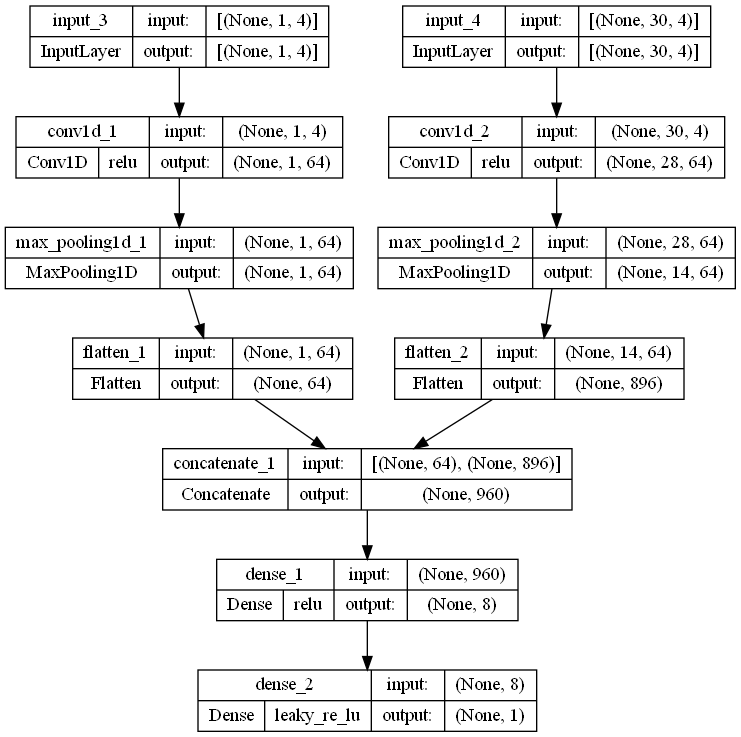

In [10]:
# plot model
from keras.utils import plot_model

plot_model(model,to_file='../.data/model_c.png', show_layer_activations=True, show_shapes=True, show_layer_names=True)

In [12]:
# train view
model_view = clone_model(model)
cp_view = ModelCheckpoint('../model/c-view.keras', save_best_only=True)
model_view.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_view.fit([X1_train, X2_train], y_train[:, 0], validation_data=([X1_val, X2_val], y_val[:, 0]), epochs=3, callbacks=[cp_view])

Epoch 1/3
49942/49942 [==============================] - 154s 3ms/step - loss: 1.5167e-06 - root_mean_squared_error: 0.0012 - val_loss: 6.7224e-06 - val_root_mean_squared_error: 0.0026
Epoch 2/3
49942/49942 [==============================] - 164s 3ms/step - loss: 1.2162e-06 - root_mean_squared_error: 0.0011 - val_loss: 6.3087e-06 - val_root_mean_squared_error: 0.0025
Epoch 3/3
49942/49942 [==============================] - 186s 4ms/step - loss: 1.1407e-06 - root_mean_squared_error: 0.0011 - val_loss: 6.1024e-06 - val_root_mean_squared_error: 0.0025


In [15]:
# train cart
model_cart = clone_model(model)
cp_cart = ModelCheckpoint('../model/c-cart.keras', save_best_only=True)
model_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_cart.fit([X1_train, X2_train], y_train[:, 1], validation_data=([X1_val, X2_val], y_val[:, 1]), epochs=3, callbacks=[cp_cart])

Epoch 1/3
49942/49942 [==============================] - 167s 3ms/step - loss: 9.4449e-06 - root_mean_squared_error: 0.0031 - val_loss: 1.1277e-05 - val_root_mean_squared_error: 0.0034
Epoch 2/3
49942/49942 [==============================] - 164s 3ms/step - loss: 8.0950e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.3127e-05 - val_root_mean_squared_error: 0.0036
Epoch 3/3
49942/49942 [==============================] - 170s 3ms/step - loss: 7.8712e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.2593e-05 - val_root_mean_squared_error: 0.0035


In [16]:
# train remove_from_cart
model_remove_from_cart = clone_model(model)
cp_remove_from_cart = ModelCheckpoint('../model/c-remove_from_cart.keras', save_best_only=True)
model_remove_from_cart.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_remove_from_cart.fit([X1_train, X2_train], y_train[:, 2], validation_data=([X1_val, X2_val], y_val[:, 2]), epochs=3, callbacks=[cp_remove_from_cart])

Epoch 1/3
49942/49942 [==============================] - 168s 3ms/step - loss: 8.2239e-05 - root_mean_squared_error: 0.0091 - val_loss: 9.9273e-05 - val_root_mean_squared_error: 0.0100
Epoch 2/3
49942/49942 [==============================] - 169s 3ms/step - loss: 7.8004e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.0341e-04 - val_root_mean_squared_error: 0.0102
Epoch 3/3
49942/49942 [==============================] - 163s 3ms/step - loss: 7.6684e-05 - root_mean_squared_error: 0.0088 - val_loss: 9.7637e-05 - val_root_mean_squared_error: 0.0099


In [17]:
# train purchase
model_purchase = clone_model(model)
cp_purchase = ModelCheckpoint('../model/c-purchase.keras', save_best_only=True)
model_purchase.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model_purchase.fit([X1_train, X2_train], y_train[:, 3], validation_data=([X1_val, X2_val], y_val[:, 3]), epochs=3, callbacks=[cp_purchase])

Epoch 1/3
49942/49942 [==============================] - 179s 4ms/step - loss: 3.4101e-05 - root_mean_squared_error: 0.0058 - val_loss: 2.5114e-05 - val_root_mean_squared_error: 0.0050
Epoch 2/3
49942/49942 [==============================] - 199s 4ms/step - loss: 3.1047e-05 - root_mean_squared_error: 0.0056 - val_loss: 2.4523e-05 - val_root_mean_squared_error: 0.0050
Epoch 3/3
49942/49942 [==============================] - 158s 3ms/step - loss: 3.0245e-05 - root_mean_squared_error: 0.0055 - val_loss: 2.9499e-05 - val_root_mean_squared_error: 0.0054
